# Analítica de datos - ejemplo de clase

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from funciones_housing import dummy_transformer, pre_exploratorio, save_fig

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

Xdata = pd.read_csv(csv_path)

In [2]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "median_house_value"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

## Análisis exploratorio incial

Incluye: reducción de dimensión con PCA y t-SNE y ranking de relvancia por pca. Se puede complementar con diagramas de caja, de pastel, matrices de correlación, probabilidades condicionales, y agrupamiento (según la aplicación).

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 14448 samples in 0.026s...
[t-SNE] Computed neighbors for 14448 samples in 3.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14448
[t-SNE] Computed conditional probabilities for sample 2000 / 14448
[t-SNE] Computed conditional probabilities for sample 3000 / 14448
[t-SNE] Computed conditional probabilities for sample 4000 / 14448
[t-SNE] Computed conditional probabilities for sample 5000 / 14448
[t-SNE] Computed conditional probabilities for sample 6000 / 14448
[t-SNE] Computed conditional probabilities for sample 7000 / 14448
[t-SNE] Computed conditional probabilities for sample 8000 / 14448
[t-SNE] Computed conditional probabilities for sample 9000 / 14448
[t-SNE] Computed conditional probabilities for sample 10000 / 14448
[t-SNE] Computed conditional probabilities for sample 11000 / 14448
[t-SNE] Computed conditional probabilities for sample 12000 / 14448
[t-SNE] Computed conditional probabilities for sa

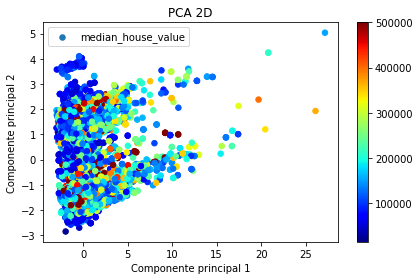

Guardando... relevancia_PCA


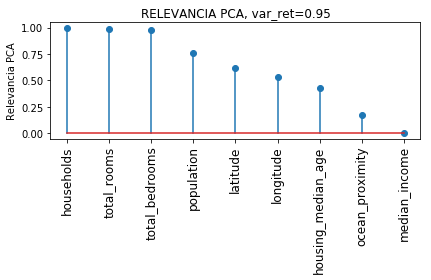

Guardando... tsne_2D


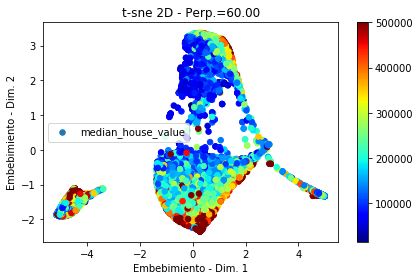

True

In [3]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
ytrain = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytrain))
Xtrain_pre = dummy_transformer().fit_transform(Xtrain)
pre_exploratorio(Xtrain_pre,ytrain,img_path,col_sal)

# Entrenar modelo según aplicación (clasificación, regresión, agrupamiento)


In [8]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA 

steps=[('dummy_pre', dummy_transformer()),
       ('rep',  PCA()),
            ('reg', RandomForestRegressor())]
parameters = {'dummy_pre__code_cat':["ordinal","binary"], 
              'dummy_pre__num_strategy':["median","most_frequent"],
              'rep__n_components' : [0.7,0.8,0.9,0.95],              
              'reg__max_depth': [8,10,12],
              'reg__n_estimators' : [10,20,40,100],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=5,
                           scoring='neg_mean_absolute_error',verbose=10)

grid_search.fit(Xtrain, ytrain)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   25.8s
[Parallel(


Mejores parámetros:

{'dummy_pre__code_cat': 'ordinal', 'dummy_pre__num_strategy': 'most_frequent', 'reg__max_depth': 8, 'reg__n_estimators': 100, 'rep__n_components': 0.95}


# Calcular rendimiento en cojunto de test

mae(test)=33964.63
Guardando... mae_testing_set


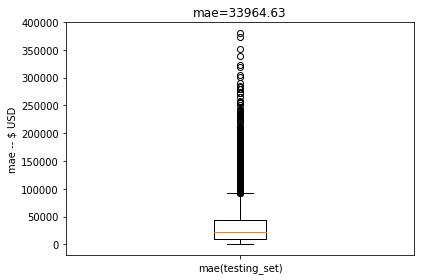

In [11]:
#%% Paso 5: evaluar sobre Xtest
ytest_e = best_model.predict(Xtest)
vmae = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(ytest_e).reshape(1,-1),multioutput='raw_values')
plt.boxplot(vmae)
print('mae(test)=%.2f' % mean_absolute_error(ytest,ytest_e))
plt.xticks([1],labels=['mae(testing_set)'])
plt.ylabel('mae -- $ USD')
plt.title('mae=%.2f'% mean_absolute_error(ytest,ytest_e))
save_fig(img_path,"mae_testing_set")
plt.show()